In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import CoolProp.CoolProp as CP
import scipy.optimize as opt
import scipy.integrate


In [2]:
#Konstanten definieren

fluid = 'R717' #Kältemittel

T_Vorlauf = 60+273.15 #Kondensator Vorlauftemperatur in K
T_Ruecklauf = 40+273.15 #Kondensator Ruecklauftemperatur in K (Annahme)
T_u = 4+273.15 #Umgebungstemperatur in K
T_c = 65+273.15 #Kondensator Temperatur in K (Annahme)
T_3sc = 55+273.15 #Kondensator Temperatur in K (Annahme)
T1_sh = 0+273.15 #Temperatur Überhizungung in K (Annahme)
T_2 = 105+273.15 #Temperatur Hochdruck in K


Q_h = 1000000 #Heizleistung in W
p_0 = 3.7e5 #Saugdruck in Pa 
p_c =29.5e5#Hochdruck in PA




In [3]:
# Zustandspunkte berechnen

def calc_ZP(T1_sh, T_2, T_3sc, p_0 = 3.7e5, p_c = 29.5e5, fluid = 'R717'):
    
    p = np.zeros(4)
    T = np.zeros(4)
    h = np.zeros(4)
    s = np.zeros(4)
    v = np.zeros(4)
    
    # Punkt 1: Austritt Verdampfer (überhitzt)
    p[0] = p_0  # Saugdruck
    T[0] = T1_sh  # Temperatur
    h[0] = CP.PropsSI('H', 'T', T1_sh, 'P', p_0, fluid)  # Enthalpie in J/kg
    s[0] = CP.PropsSI('S', 'T', T1_sh, 'P', p_0, fluid)  # Entropie in J/kg/K
    v[0] = CP.PropsSI('D', 'T', T1_sh, 'P', p_0, fluid)  # spezifisches Volumen in m³/kg

    # Punkt 2: Austritt Verdichter
    p[1] = p_c  # Hochdruck
    T[1] = T_2  # Temperatur
    s[1] = CP.PropsSI('S', 'T', T[1], 'P', p[1], fluid)  # isentrope Verdichtung
    h[1] = CP.PropsSI('H', 'P', p[1], 'S', s[1], fluid)  # isentrope Enthalpie
    v[1] = CP.PropsSI('D', 'T', T[1], 'P', p[1], fluid)  # spezifisches Volumen in m³/kg


    # Punkt 3: Austritt Kondensator
    p[2] = p[1]  # Hochdruck
    T[2] = T_3sc  # Temperatur
    h[2] = CP.PropsSI('H', 'T', T[2], 'P', p[2], fluid)  # Enthalpie
    s[2] = CP.PropsSI('S', 'T', T[2], 'P', p[2], fluid)  # Entropie
    v[2] = CP.PropsSI('D', 'T', T[2], 'P', p[2], fluid)  # spezifisches Volumen in m³/kg

    # Punkt 4: Austritt Drossel
    p[3] = p_0  # Saugdruck
    h[3] = h[2]  # isenthalpische Drosselung
    T[3] = CP.PropsSI('T', 'P', p[3], 'H', h[3], fluid)  # Temperatur
    s[3] = CP.PropsSI('S', 'P', p[3], 'H', h[3], fluid)  # Entropie
    v[3] = CP.PropsSI('D', 'P', p[3], 'H', h[3], fluid)  # spezifisches Volumen in m³/kg
    
    return p, T, h, s, v




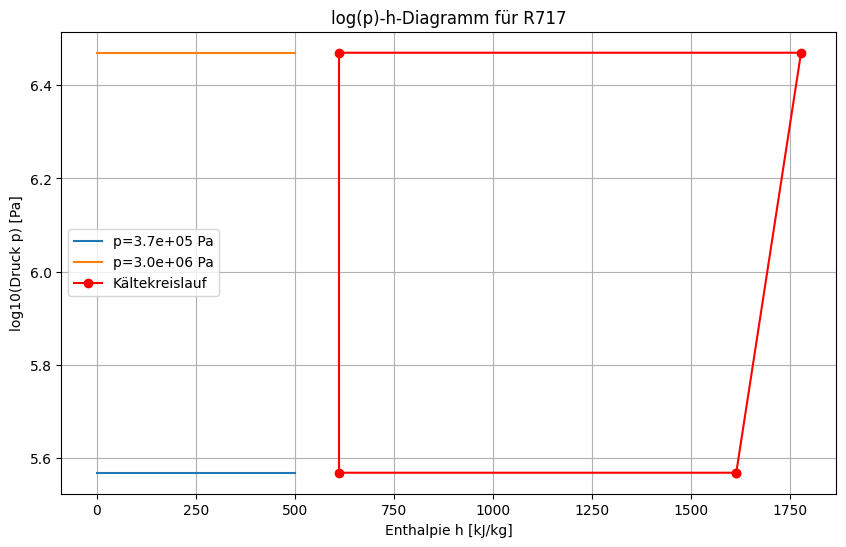

In [8]:
p, T, h, s, v = calc_ZP(T1_sh, T_2, T_3sc)
# log(p)-h-Diagramm plotten
h_vals = np.linspace(0, 500000, 500)  # Enthalpie-Werte
p_vals = np.logspace(4, 7, 500)  # Druck-Werte

plt.figure(figsize=(10, 6))
for P in [p_0, p_c]:
    T_vals = CP.PropsSI('T', 'P', P, 'H', h_vals, fluid)
    plt.plot(h_vals / 1000, np.log10(P) * np.ones_like(h_vals), label=f'p={P:.1e} Pa')

# Zustandspunkte eintragen
points_h = [h[0], h[1], h[2], h[3], h[0]]
points_p = [p[0], p[1], p[2], p[3], p[0]]
plt.plot(np.array(points_h) / 1000, np.log10(points_p), 'ro-', label='Kältekreislauf')

plt.title('log(p)-h-Diagramm für R717')
plt.xlabel('Enthalpie h [kJ/kg]')
plt.ylabel('log10(Druck p) [Pa]')
plt.legend()
plt.grid()
plt.show()


In [10]:
# Berechnung des nötigen Massestroms
m_dot = Q_h / (h[1] - h[2])  # Massestrom in kg/s

# Berechnung der Kälteleistung
Q_c = m_dot * (h[0] - h[3])  # Kälteleistung in W
P_verd = m_dot * (h[1] - h[0])  # Verdichterleistung in W
COP = Q_h / P_verd  # Coefficient of Performance

print(f"Massestrom: {m_dot:.2f} kg/s")
print(f"Kälteleistung: {Q_c/1e3:.2f} kW")
print(f"Verdichterleistung: {P_verd/1e3:.2f} kW")
print(f"Coefficient of Performance (COP): {COP:.2f}")

Massestrom: 0.86 kg/s
Kälteleistung: 859.75 kW
Verdichterleistung: 140.25 kW
Coefficient of Performance (COP): 7.13
